In [8]:
# !python3 -m pip install seaborn
# ! pip install pymc3
# ! pip install arviz
! pip install --upgrade pandas

zsh:1: /usr/local/bin/pip: bad interpreter: /System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: no such file or directory
  Using cached pandas-1.5.2-cp39-cp39-macosx_10_9_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.2
    Uninstalling pandas-1.4.2:
      Successfully uninstalled pandas-1.4.2


In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import numpy as np
from tqdm import tqdm
import scipy.stats as stats
from scipy.signal import find_peaks, peak_widths
import itertools
import pandas as pd
# import pymc3 as pm
# import arviz as az
from datetime import datetime as dt
# import igraph as ig
# from statsmodels.stats.weightstats import ztest
from rdkit import Chem
from rdkit.Chem import Descriptors

In [2]:
## Matplotlib defaults ##
colors = {"5": "#aa0f35", 
         "6": "#fdc799",
         "7": "#a0a75c",
         "8": "#603734",
         "9": "#abdbfc",
         "10": "#313a61",
         "15": "#bfbad5",
         "20": "#f89b00",
         "full": "#313862",
         "new": "#FAB124"}

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.style.use("default")
plt.rcParams.update({'font.size': 22})
# plt.style.use("dark_background")

# Overview

Analyze assembly index calculations across patent data. These calculations are from random samples of compounds present in each month from 1980-2019.

//TODO: sample from new compounds added in each month

In [3]:
fp = "Data/AssemblyValues/assembly_values_1000_1980.p"
assembly_values = pickle.load(file=open(fp, "rb"))

In [ ]:
print(assembly_values[100:199])

In [4]:
def build_month_increments(start, stop):
    """ Build all monthly increments from the start year to stop year in the
    format YEAR-MONTH

    Args:
        start (int): start year of increments
        stop (int): end year of increments

    Returns:
        list: list of strings holding the YEAR-MONTH increments
    """
    months = []
    while start <= stop:
        for month in [
                "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
                "11", "12"
        ]:
            months.append(str(start) + "-" + month)
        start += 1

    return months

In [5]:
months = build_month_increments(1980, 1980)
print(months)

['1980-01', '1980-02', '1980-03', '1980-04', '1980-05', '1980-06', '1980-07', '1980-08', '1980-09', '1980-10', '1980-11', '1980-12']


# New / Total Compound Assemblies (AssemblyGo)

Read in AssemblyGo results, split data into months, graph from there


In [73]:
#Read in full and new dataframes
fp = "Data/AssemblyValues/"
full_df = pd.read_csv(fp + "FullDatabase_AssemblyGo.csv")
new_df = pd.read_csv(fp + "NewDatabase_AssemblyGo.csv")

In [4]:
print(full_df.head())

   Unnamed: 0           label  MA_assemblyGo
0           0  1994-03_365031             13
1           1  1994-09_370717             11
2           2   2017-11_80436             22
3           3  2010-04_214306              9
4           4  2005-11_267327             12


In [74]:
def get_month(label):
    """ Isolates the month from the given label

    Args:
        label (str): compound id in the form YYYY-MM_label

    Returns:
        str: YYYY-MM of a particular compound
    """
    return str(label)[:7]

In [75]:
#Apply to full and new dataframes
tqdm.pandas()

full_df["month"] = full_df["label"].apply(get_month)
new_df["month"] = new_df["label"].apply(get_month)

full_df = full_df.dropna()
new_df = new_df.dropna()

print(full_df)


        Unnamed: 0           label  MA_assemblyGo    month
0                0  1994-03_365031             13  1994-03
1                1  1994-09_370717             11  1994-09
2                2   2017-11_80436             22  2017-11
3                3  2010-04_214306              9  2010-04
4                4  2005-11_267327             12  2005-11
...            ...             ...            ...      ...
467872      467872  2018-01_433720             21  2018-01
467873      467873  2016-12_420694             30  2016-12
467874      467874  1997-05_238251              7  1997-05
467875      467875  1993-03_283329             24  1993-03
467876      467876  1982-10_184989             16  1982-10

[466872 rows x 4 columns]


In [76]:
full_stats = full_df.groupby(["month"]).agg({"MA_assemblyGo":["mean","std"]})
new_stats = new_df.groupby(["month"]).agg({"MA_assemblyGo":["mean","std"]})

full_stats = full_stats.dropna(axis=0)
new_stats = new_stats.dropna(axis=0)

print(full_stats)
print("----------------------------------")
print(new_stats)


        MA_assemblyGo          
                 mean       std
month                          
1980-01     11.427544  5.496739
1980-02     11.637985  5.959078
1980-03     11.574227  5.817411
1980-04     11.903704  6.119765
1980-05     11.895228  6.340823
...               ...       ...
2019-08     17.795753  8.946237
2019-09     17.927329  9.091736
2019-10     18.435664  9.492319
2019-11     17.867147  9.534088
2019-12     16.433943  9.277880

[480 rows x 2 columns]
----------------------------------
        MA_assemblyGo          
                 mean       std
month                          
1980-01     14.143757  6.157706
1980-02     13.960581  5.858003
1980-03     13.801031  5.717696
1980-04     14.392968  6.179733
1980-05     13.453305  5.613438
...               ...       ...
2019-08     20.486815  8.461578
2019-09     20.653846  8.786538
2019-10     21.712398  9.869216
2019-11     21.838843  9.482737
2019-12     20.366935  9.087557

[480 rows x 2 columns]


In [77]:
#Apply to full and new dataframes
tqdm.pandas()

full_df["month"] = full_df["label"].apply(get_month)
new_df["month"] = new_df["label"].apply(get_month)

full_df = full_df.dropna()
new_df = new_df.dropna()

print(full_df)


        Unnamed: 0           label  MA_assemblyGo    month
0                0  1994-03_365031             13  1994-03
1                1  1994-09_370717             11  1994-09
2                2   2017-11_80436             22  2017-11
3                3  2010-04_214306              9  2010-04
4                4  2005-11_267327             12  2005-11
...            ...             ...            ...      ...
467872      467872  2018-01_433720             21  2018-01
467873      467873  2016-12_420694             30  2016-12
467874      467874  1997-05_238251              7  1997-05
467875      467875  1993-03_283329             24  1993-03
467876      467876  1982-10_184989             16  1982-10

[466872 rows x 4 columns]


Text(0, 0.5, 'Assembly Index')

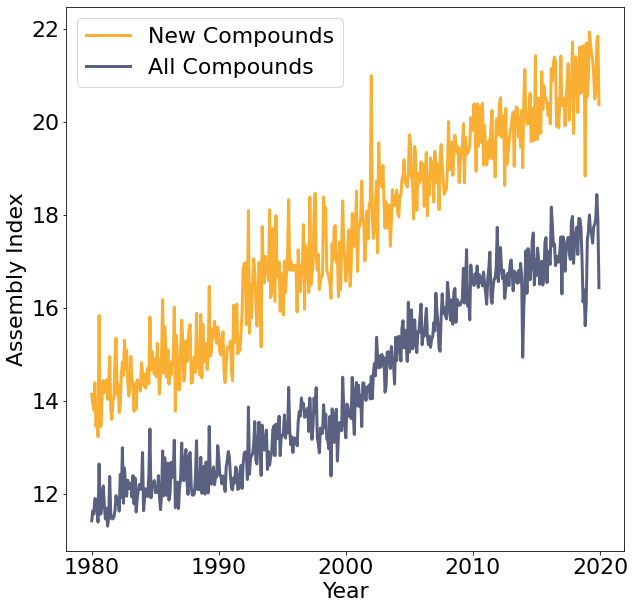

In [78]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))

plt.plot(np.arange(1980, 2020, 1/12), new_stats["MA_assemblyGo"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

plt.plot(np.arange(1980, 2020, 1/12), full_stats["MA_assemblyGo"]["mean"], color="#313a61",
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")

## Updated assembly change figure 

With more MA values (from patent scraping)

In [48]:
### Testing - need dates for compounds

cpd_dates = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Cpd_Date_Dict/cpd_date_dict_1980-01.p", "rb"))

print(list(cpd_dates.items())[0:5])

[('SCHEMBL1812', '1980-01-01'), ('SCHEMBL675157', '1980-01-01'), ('SCHEMBL1102', '1980-01-01'), ('SCHEMBL10855450', '1980-01-01'), ('SCHEMBL14421133', '1980-01-01')]


In [54]:
## Goal - have a dictionary with {ID:[dates]} for all compounds

import os
from collections import defaultdict

cpd_dates_FULL = defaultdict(list)

fp = "/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Cpd_Date_Dict/"
for f in tqdm(os.listdir(fp)):
    cpd_dates = pickle.load(file=open(fp + f, "rb"))

    for k, v in cpd_dates.items():
        cpd_dates_FULL[k].append(v)


100%|██████████| 708/708 [12:17<00:00,  1.04s/it]  


In [55]:
pickle.dump(cpd_dates_FULL, file=open(fp + "cpd_date_dict_FULL.p", "wb"))

In [4]:
fp = "/Volumes/Macintosh HD 4/SureChemBL/CpdPatentIdsDates/Cpd_Date_Dict/"

cpd_dates_FULL = pickle.load(file=open(fp + "cpd_date_dict_FULL.p", "rb"))

In [6]:
cpd_dates_FULL["SCHEMBL13106681"]

['2010-06-09', '2010-10-07', '2013-02-05']

In [ ]:
### Testing - should the novel / full distinction be used for patent compounds? 

## Time series prediction

"Moore's Law of MA" - Lee

In [14]:
# Turn dates into ordinal values (for training purposes)
months = pd.Series(full_stats.index) + "-01"

ordinals = []
datetimes = []
for date in months:
    ordinals.append(dt.strptime(date, '%Y-%m-%d').date().toordinal())
    datetimes.append(dt.strptime(date, '%Y-%m-%d').date())

full_stats["date"] = ordinals
new_stats["date"] = ordinals
print(full_stats)
print("----------")
print(new_stats)

        MA_assemblyGo              date
                 mean       std        
month                                  
1980-01     11.427544  5.496739  722815
1980-02     11.637985  5.959078  722846
1980-03     11.574227  5.817411  722875
1980-04     11.903704  6.119765  722906
1980-05     11.895228  6.340823  722936
...               ...       ...     ...
2019-08     17.795753  8.946237  737272
2019-09     17.927329  9.091736  737303
2019-10     18.435664  9.492319  737333
2019-11     17.867147  9.534088  737364
2019-12     16.433943  9.277880  737394

[480 rows x 3 columns]
----------
        MA_assemblyGo              date
                 mean       std        
month                                  
1980-01     14.143757  6.157706  722815
1980-02     13.960581  5.858003  722846
1980-03     13.801031  5.717696  722875
1980-04     14.392968  6.179733  722906
1980-05     13.453305  5.613438  722936
...               ...       ...     ...
2019-08     20.486815  8.461578  737272
2019-

In [15]:
# Number of samples
n = len(new_stats)

x = new_stats["date"].values.reshape(n, 1)
new_y = new_stats["MA_assemblyGo"]["mean"].values.reshape(n, 1)
full_y = new_stats["MA_assemblyGo"]["mean"].values.reshape(n, 1)

# Train-test split (train on 70%)
prop_train = 0.7
n_train = round(prop_train * n)

In [16]:
#Train new values first
x_train = x[:n_train]
y_train = new_y[:n_train]

x_test = x[n_train:]
y_test = new_y[n_train:]

### Gaussian Process

Using https://juanitorduz.github.io/gp_ts_pymc3/ for help

In [77]:
#Set up & train prediction model

with pm.Model() as model:
    # Use a squared exponential kernal, default (?) parameters
    l = 10.0
    tau = 2.0
    b = 0.5
    cov = b + tau + pm.gp.cov.ExpQuad(1, l)

    # # Squared exponential didn't work - let's try default linear instead (failed! And takes ~30 minutes)
    # cov = pm.gp.cov.Linear(input_dim=1, c=pm.Normal(name="c_3", mu=1, sigma=2))

    gp = pm.gp.Marginal(cov_func=cov)

    #Noise (if necessary?)
    sigma = pm.HalfNormal(name="sigma", sigma=10)

    #Likelihood
    y_pred = gp.marginal_likelihood("y_pred", X=x_train, y=y_train.flatten(), noise=sigma)

    #Sample
    trace = pm.sample(draws=500, chains=2, tune=500)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 96 seconds.


In [78]:
# Train 
with model:
    x_train_conditional_2 = gp.conditional("x_train_conditional_2", x_train)
    y_train_pred_samples = pm.fast_sample_posterior_predictive(trace, var_names=["x_train_conditional_2"], samples=100)

    x_test_conditional_2 = gp.conditional("x_test_conditional_2", x_test)
    y_test_pred_samples = pm.fast_sample_posterior_predictive(trace, var_names=["x_test_conditional_2"], samples=100)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pymc3/distributions/posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [79]:
#Prediction sample statistics
y_train_pred_samples_mean = y_train_pred_samples['x_train_conditional_2'].mean(axis=0)
y_train_pred_samples_std = y_train_pred_samples['x_train_conditional_2'].std(axis=0)
y_train_pred_samples_mean_plus = y_train_pred_samples_mean + 2*y_train_pred_samples_std
y_train_pred_samples_mean_minus = y_train_pred_samples_mean - 2*y_train_pred_samples_std
# Test
y_test_pred_samples_mean = y_test_pred_samples['x_test_conditional_2'].mean(axis=0)
y_test_pred_samples_std = y_test_pred_samples['x_test_conditional_2'].std(axis=0)
y_test_pred_samples_mean_plus = y_test_pred_samples_mean + 2*y_test_pred_samples_std
y_test_pred_samples_mean_minus = y_test_pred_samples_mean - 2*y_test_pred_samples_std


[Text(0.5, 1.0, 'Model Predictions'), Text(0.5, 0, 't'), Text(0, 0.5, '')]

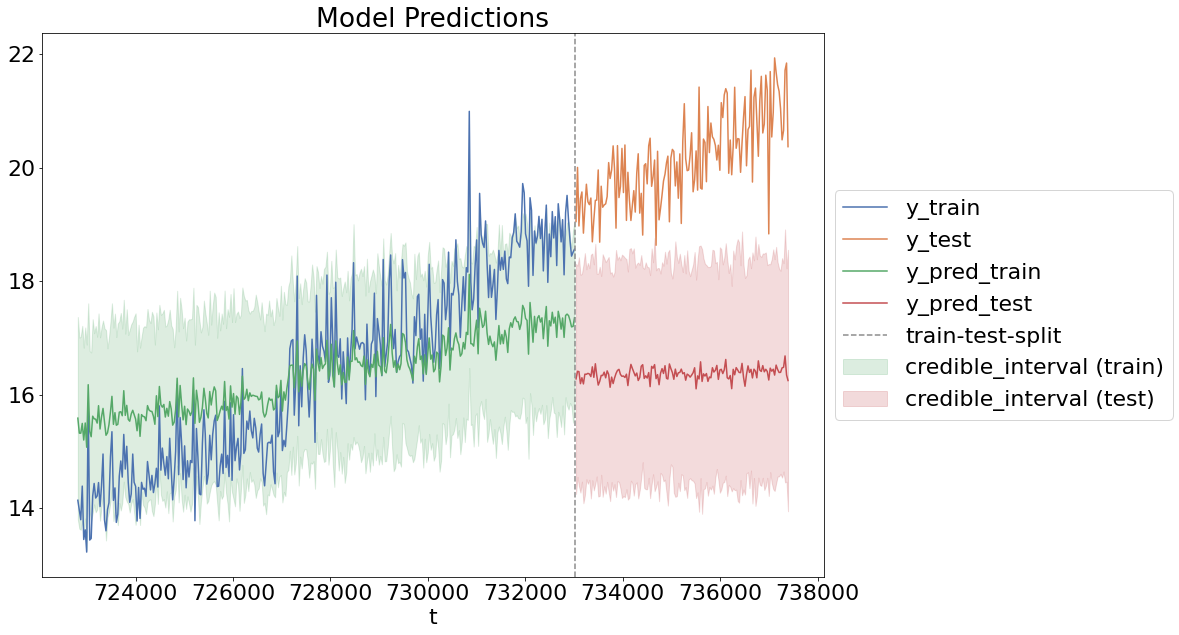

In [80]:
fig, ax = plt.subplots(figsize=(14,10))

sns_c = sns.color_palette(palette='deep')

sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color=sns_c[1], label='y_test', ax=ax)
ax.fill_between(
    x=x_train.flatten(), 
    y1=y_train_pred_samples_mean_minus, 
    y2=y_train_pred_samples_mean_plus, 
    color=sns_c[2], 
    alpha=0.2, 
    label='credible_interval (train)'
)
sns.lineplot(x=x_train.flatten(), y=y_train_pred_samples_mean, color=sns_c[2], label='y_pred_train', ax=ax)
ax.fill_between(
    x=x_test.flatten(), 
    y1=y_test_pred_samples_mean_minus, 
    y2=y_test_pred_samples_mean_plus, 
    color=sns_c[3], 
    alpha=0.2, 
    label='credible_interval (test)'
)
sns.lineplot(x=x_test.flatten(), y=y_test_pred_samples_mean, color=sns_c[3], label='y_pred_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Model Predictions', xlabel='t', ylabel='')


### AutoAIRMA

Using first test in https://towardsdatascience.com/3-unique-python-packages-for-time-series-forecasting-2926a09aaf5b

In [17]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, SimpleExponentialSmoothing

In [18]:
## Get dataframes with dates (necessary for the AutoARIMA model)
full_df = full_df.groupby(["month"]).agg({"MA_assemblyGo":["mean","std"]}).reset_index()

new_df = new_df.groupby(["month"]).agg({"MA_assemblyGo":["mean","std"]}).reset_index()

print(full_df)

       month MA_assemblyGo          
                      mean       std
0    1980-01     11.427544  5.496739
1    1980-02     11.637985  5.959078
2    1980-03     11.574227  5.817411
3    1980-04     11.903704  6.119765
4    1980-05     11.895228  6.340823
..       ...           ...       ...
475  2019-08     17.795753  8.946237
476  2019-09     17.927329  9.091736
477  2019-10     18.435664  9.492319
478  2019-11     17.867147  9.534088
479  2019-12     16.433943  9.277880

[480 rows x 3 columns]


In [65]:
#Ensure proper dataframe setup (remove groupby association, change month to datetimes)
full_df_SF = pd.DataFrame()
full_df_SF["ds"] = datetimes
full_df_SF["y"] = full_df["MA_assemblyGo"]["mean"]
full_df_SF["unique_id"] = [0] * len(full_df_SF)
full_df_SF = full_df_SF.set_index("unique_id")
full_df_SF.reset_index()
print(full_df_SF)

print("----------")

new_df_SF = pd.DataFrame()
new_df_SF["ds"] = datetimes
new_df_SF["y"] = new_df["MA_assemblyGo"]["mean"]
new_df_SF["unique_id"] = [0] * len(new_df_SF)
new_df_SF = new_df_SF.set_index("unique_id")
new_df_SF.reset_index()

print(new_df_SF)


                   ds          y
unique_id                       
0          1980-01-01  11.427544
0          1980-02-01  11.637985
0          1980-03-01  11.574227
0          1980-04-01  11.903704
0          1980-05-01  11.895228
...               ...        ...
0          2019-08-01  17.795753
0          2019-09-01  17.927329
0          2019-10-01  18.435664
0          2019-11-01  17.867147
0          2019-12-01  16.433943

[480 rows x 2 columns]
----------
                   ds          y
unique_id                       
0          1980-01-01  14.143757
0          1980-02-01  13.960581
0          1980-03-01  13.801031
0          1980-04-01  14.392968
0          1980-05-01  13.453305
...               ...        ...
0          2019-08-01  20.486815
0          2019-09-01  20.653846
0          2019-10-01  21.712398
0          2019-11-01  21.838843
0          2019-12-01  20.366935

[480 rows x 2 columns]


In [66]:
## Set up training/test dataframes
Y_trainNEW_df = new_df_SF[:n_train]
Y_testNEW_df = new_df_SF[n_train:]

Y_trainFULL_df = full_df_SF[:n_train]
Y_testFULL_df = full_df_SF[n_train:]

print(Y_trainNEW_df.head())
print("-----")
print(Y_trainFULL_df.head())

                   ds          y
unique_id                       
0          1980-01-01  14.143757
0          1980-02-01  13.960581
0          1980-03-01  13.801031
0          1980-04-01  14.392968
0          1980-05-01  13.453305
-----
                   ds          y
unique_id                       
0          1980-01-01  11.427544
0          1980-02-01  11.637985
0          1980-03-01  11.574227
0          1980-04-01  11.903704
0          1980-05-01  11.895228


In [67]:
## Set up model parameters

season_length = 12 #example is built on 12-month-long cyclical data, but this might work for me too...
horizon = len(Y_testNEW_df)

models = [
AutoARIMA(season_length = season_length),
AutoETS(season_length = season_length, model='ZZZ'),
SimpleExponentialSmoothing(0.99)
]

modelNEW = StatsForecast(
df=Y_trainNEW_df,
models=models,
freq='M',
n_jobs=-1)

modelFULL = StatsForecast(
df=Y_trainFULL_df,
models=models,
freq='M',
n_jobs=-1)

In [68]:
## NOTE: takes ~5 seconds

# Addition to horizon is the number of months in the future (120 corresponds to 10 years)

Y_hatNEW_df = modelNEW.forecast(horizon + 120, level=[95]).reset_index()
Y_hatNEW_df.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95,AutoETS,AutoETS-lo-95,AutoETS-hi-95,SES
0,0,2007-12-31,18.677120,17.476065,19.878174,18.935757,17.743162,20.128351,18.562082
1,0,2008-01-31,18.711241,17.493570,19.928911,18.950563,17.752354,20.148771,18.562082
2,0,2008-02-29,18.754230,17.520166,19.988295,18.965370,17.761560,20.169178,18.562082
3,0,2008-03-31,18.709227,17.458984,19.959469,18.980177,17.770781,20.189571,18.562082
4,0,2008-04-30,18.820787,17.554573,20.087000,18.994984,17.780016,20.209949,18.562082


In [69]:
Y_hatFULL_df = modelFULL.forecast(horizon + 120, level=[95]).reset_index()
Y_hatFULL_df.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95,AutoETS,AutoETS-lo-95,AutoETS-hi-95,SES
0,0,2007-12-31,15.786119,15.015878,16.556360,15.831540,15.072398,16.590683,15.764064
1,0,2008-01-31,15.786119,15.001996,16.570242,15.844036,15.078122,16.609951,15.764064
2,0,2008-02-29,15.786119,14.988357,16.583881,15.856532,15.083895,16.629169,15.764064
3,0,2008-03-31,15.786119,14.974945,16.597292,15.869028,15.089716,16.648340,15.764064
4,0,2008-04-30,15.786119,14.961753,16.610485,15.881524,15.095585,16.667463,15.764064


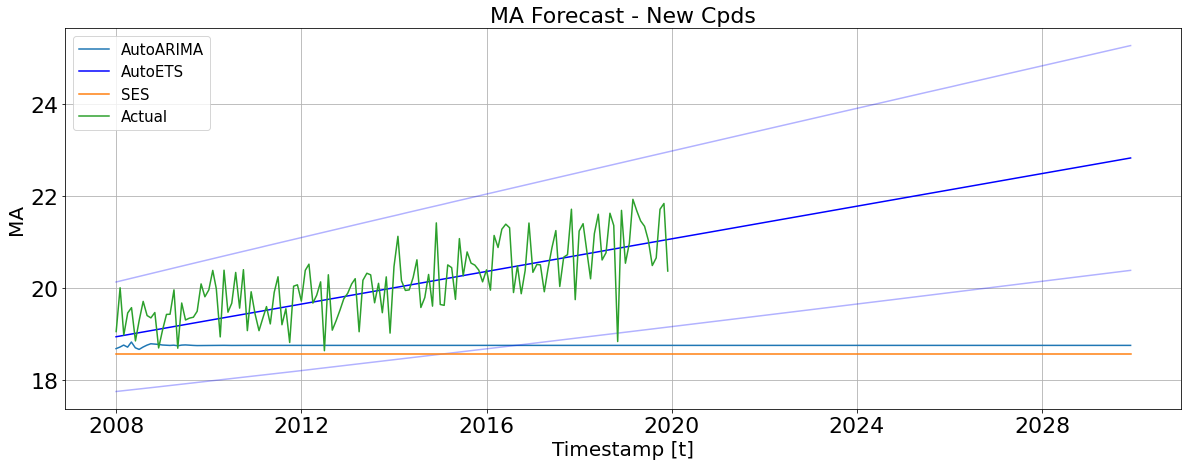

In [70]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["AutoARIMA"], label="AutoARIMA")
plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["AutoETS"], label="AutoETS", color="blue")
plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["AutoETS-lo-95"], color="blue", alpha=0.3)
plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["AutoETS-hi-95"], color="blue", alpha=0.3)

plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["SES"], label="SES")

plt.plot(Y_testNEW_df["ds"], Y_testNEW_df["y"], label="Actual")

#plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
# plot_df[['y', 'AutoARIMA', 'ETS']].plot(ax=ax, linewidth=2)

ax.set_title('MA Forecast - New Cpds', fontsize=22)
ax.set_ylabel('MA', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

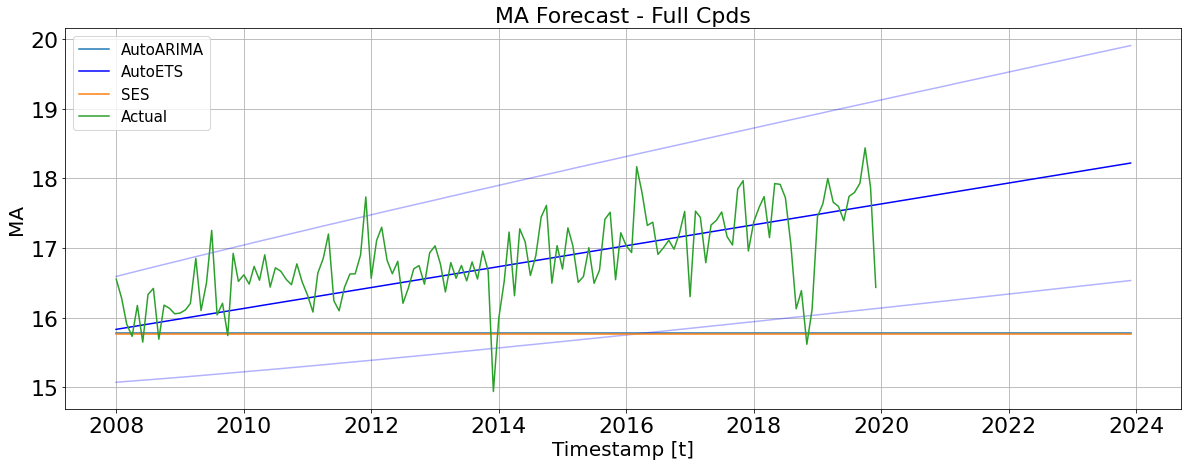

In [64]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plt.plot(Y_hatFULL_df["ds"], Y_hatFULL_df["AutoARIMA"], label="AutoARIMA")
plt.plot(Y_hatFULL_df["ds"], Y_hatFULL_df["AutoETS"], label="AutoETS", color="blue")
plt.plot(Y_hatFULL_df["ds"], Y_hatFULL_df["AutoETS-lo-95"], color="blue", alpha=0.3)
plt.plot(Y_hatFULL_df["ds"], Y_hatFULL_df["AutoETS-hi-95"], color="blue", alpha=0.3)

plt.plot(Y_hatFULL_df["ds"], Y_hatFULL_df["SES"], label="SES")

plt.plot(Y_testFULL_df["ds"], Y_testFULL_df["y"], label="Actual")

#plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
# plot_df[['y', 'AutoARIMA', 'ETS']].plot(ax=ax, linewidth=2)

ax.set_title('MA Forecast - Full Cpds', fontsize=22)
ax.set_ylabel('MA', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [81]:
print(list(Y_hatNEW_df["ds"])[-35:])

[Timestamp('2021-01-31 00:00:00'), Timestamp('2021-02-28 00:00:00'), Timestamp('2021-03-31 00:00:00'), Timestamp('2021-04-30 00:00:00'), Timestamp('2021-05-31 00:00:00'), Timestamp('2021-06-30 00:00:00'), Timestamp('2021-07-31 00:00:00'), Timestamp('2021-08-31 00:00:00'), Timestamp('2021-09-30 00:00:00'), Timestamp('2021-10-31 00:00:00'), Timestamp('2021-11-30 00:00:00'), Timestamp('2021-12-31 00:00:00'), Timestamp('2022-01-31 00:00:00'), Timestamp('2022-02-28 00:00:00'), Timestamp('2022-03-31 00:00:00'), Timestamp('2022-04-30 00:00:00'), Timestamp('2022-05-31 00:00:00'), Timestamp('2022-06-30 00:00:00'), Timestamp('2022-07-31 00:00:00'), Timestamp('2022-08-31 00:00:00'), Timestamp('2022-09-30 00:00:00'), Timestamp('2022-10-31 00:00:00'), Timestamp('2022-11-30 00:00:00'), Timestamp('2022-12-31 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-28 00:00:00'), Timestamp('2023-03-31 00:00:00'), Timestamp('2023-04-30 00:00:00'), Timestamp('2023-05-31 00:00:00'), Timestamp('20

Text(0, 0.5, 'Assembly Index')

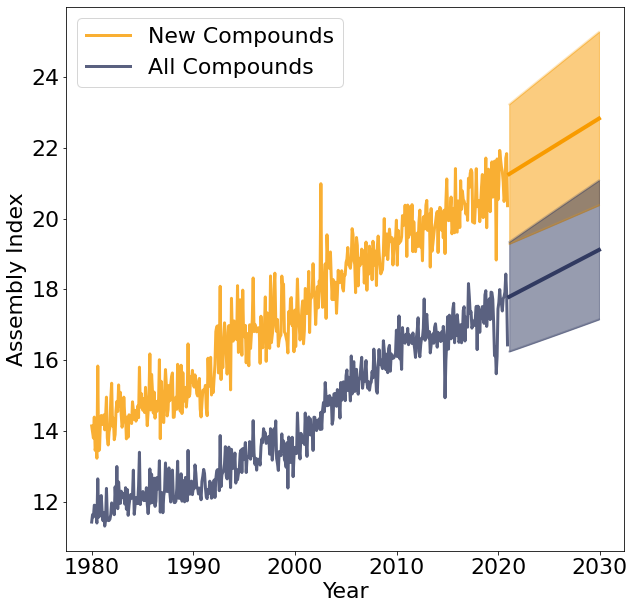

In [79]:
#Assembly values with standard deviation & predicted values (from autoETS)
plt.figure(figsize=(10,10))

new_color = "#f89b00"
full_color= "#313a61"
xs = pd.date_range(start = "1980-01-01", end = "2020-12-01", periods = 480).to_pydatetime().tolist()

plt.plot(xs, new_stats["MA_assemblyGo"]["mean"], color=new_color,
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

## cutoff is the prediction level (number of months in the future, minus 13 - not entirely sure why this works)
cutoff = 120 - 13

#New cpd prediction
plt.plot(list(Y_hatNEW_df["ds"])[-cutoff:], list(Y_hatNEW_df["AutoETS"])[-cutoff:], color=new_color,
    linewidth=4)
plt.plot(list(Y_hatNEW_df["ds"])[-cutoff:], list(Y_hatNEW_df["AutoETS-lo-95"])[-cutoff:], color=new_color,
    linewidth=2, alpha=0.25)
plt.plot(list(Y_hatNEW_df["ds"])[-cutoff:], list(Y_hatNEW_df["AutoETS-hi-95"])[-cutoff:], color=new_color,
    linewidth=2, alpha=0.25)

plt.fill_between(list(Y_hatNEW_df["ds"])[-cutoff:], list(Y_hatNEW_df["AutoETS-lo-95"])[-cutoff:], 
    list(Y_hatNEW_df["AutoETS-hi-95"])[-cutoff:], color=new_color, alpha=0.5)


#Full cpd plotting
plt.plot(xs, full_stats["MA_assemblyGo"]["mean"], color=full_color,
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

#Full cpd prediction
plt.plot(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS"])[-cutoff:], color=full_color,
    linewidth=4)
plt.plot(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS-lo-95"])[-cutoff:], color=full_color,
    linewidth=2, alpha=0.25)
plt.plot(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS-hi-95"])[-cutoff:], color=full_color,
    linewidth=2, alpha=0.25)

plt.fill_between(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS-lo-95"])[-cutoff:], 
    list(Y_hatFULL_df["AutoETS-hi-95"])[-cutoff:], color=full_color, alpha=0.5)

plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")

In [80]:
### Percent coverage at last predicted timestep - should be comparable with MA

final_ma_low = list(Y_hatFULL_df["AutoETS-lo-95"])[-1]
final_ma_high = list(Y_hatFULL_df["AutoETS-hi-95"])[-1]
final_ma_predicted = list(Y_hatFULL_df["AutoETS"])[-1]

print(final_ma_high)
print(final_ma_predicted)

mw_percent = final_ma_predicted / final_ma_high
print("Percent coverage:", (1 - mw_percent) * 100 )

21.082412719726562
19.117979049682617
Percent coverage: 9.31787882231263


## Try simple exponential smoothing

From statsforecast (for now): https://nixtla.github.io/statsforecast/models.html#exponentialsmoothing

In [91]:
models = [
SimpleExponentialSmoothing(0.2)
]

model = StatsForecast(
df=Y_train_df,
models=models,
freq='M',
n_jobs=-1)

In [118]:
Y_hat_df = model.forecast(horizon).reset_index()
Y_hat_df.head()


,unique_id,ds,SES
0,0,1980-01-31,14.143757
1,0,1980-02-29,14.143757
2,0,1980-03-31,14.143757
3,0,1980-04-30,14.143757
4,0,1980-05-31,14.143757


In [119]:
y_hat_ds = list(set(list(Y_hat_df["ds"])))
Y_hat_df_2 = Y_hat_df.groupby("unique_id")


In [125]:
print(Y_hat_df_2.head())
print(list(Y_hat_df[Y_hat_df["unique_id"] == 335]["SES"]))

       unique_id         ds        SES
0              0 1980-01-31  14.143757
1              0 1980-02-29  14.143757
2              0 1980-03-31  14.143757
3              0 1980-04-30  14.143757
4              0 1980-05-31  14.143757
...          ...        ...        ...
48240        335 2007-12-31  18.562628
48241        335 2008-01-31  18.562628
48242        335 2008-02-29  18.562628
48243        335 2008-03-31  18.562628
48244        335 2008-04-30  18.562628

[1680 rows x 3 columns]
[18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18.5626277923584, 18

In [117]:
print(len(y_hat_ds))
print(len(Y_hat_df))

479
336


ValueError: x and y must be the same size

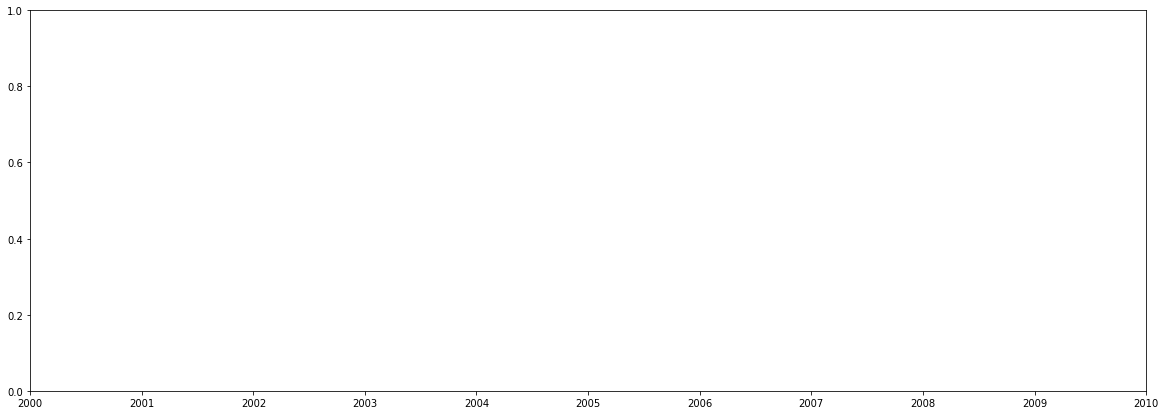

In [111]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

#Plot SES
plt.scatter(y_hat_ds, Y_hat_df["SES"]["mean"], label="SES")

#Plot actual Y
plt.plot(Y_train_df["ds"], Y_train_df["y"], label="Y", color="orange")
plt.plot(Y_test_df["ds"], Y_test_df["y"], color="orange")

ax.set_title('Forecast Synthetic Data', fontsize=22)
ax.set_ylabel('Number', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# New / Total Compound Assemblies (Monte Carlo)

There are varying numbers of compounds for each month - so it's necessary to make separate lists for each month. These are stored in a dictionary {month: [assembly values]}

### Plotting

Plot mean, standard deviation, other data for each month

Using two files = fullCpds_ & newCpds_AssemblyValues.csv in Data/AssemblyValues

Goal = get average & std MA, as well as average avg MW, for each month

In [33]:
full_df_old = pd.read_csv("Data/AssemblyValues/fullCpds_AssemblyValues.csv")
new_df_old = pd.read_csv("Data/AssemblyValues/newCpds_AssemblyValues.csv")
print(full_df_old.head())
print("----------------------------------")
print(new_df_old.head())

   Unnamed: 0    month                                              inchi  ai  \
0           0  2003-01             InChI=1S/C6H5Cl/c7-6-4-2-1-3-5-6/h1-5H   4   
1           1  2003-01  InChI=1S/C4H8O2.C3H8O/c1-3-6-4(2)5;1-3(2)4/h3H...   3   
2           2  2003-01  InChI=1S/C31H46O2/c1-22(2)12-9-13-23(3)14-10-1...  18   
3           3  2003-01  InChI=1S/C29H32O13/c1-11-36-9-20-27(40-11)24(3...  28   
4           4  2003-01  InChI=1S/C12H22N4O11P2/c1-16(2,3)26-29(22,23)2...  26   

           mw  
0  112.007978  
1  148.109944  
2  450.349781  
3  588.184291  
4  460.076031  
----------------------------------
   Unnamed: 0    month                                              inchi  ai  \
0           0  1996-01  InChI=1S/C12H19NO2/c1-3-4-5-6-8-11(2)15-12(14)...  11   
1           1  1996-01  InChI=1S/C14H10ClN3S2/c15-11-4-2-1-3-10(11)13-...  18   
2           2  1996-01  InChI=1S/C8H10N2O2/c9-7-3-1-6(2-4-7)5-12-8(10)...   9   
3           3  1996-01  InChI=1S/C13H21NO2/c1-10(9-14(3)4)

In [34]:
#Average mw values per month
full_stats = full_df_old.groupby(["month"]).agg({"ai":["mean","std"],"mw":["mean"]})
new_stats = new_df_old.groupby(["month"]).agg({"ai":["mean","std"],"mw":["mean"]})

print(full_stats)
print("----------------------------------")
print(new_stats)

                ai                     mw
              mean        std        mean
month                                    
1980-01  14.542477   8.578500  288.903786
1980-02  14.957113   9.432218  296.786454
1980-03  14.758230   8.803624  294.921734
1980-04  15.343189   9.410054  301.813923
1980-05  15.006224   9.419604  294.044223
...            ...        ...         ...
2019-08  23.524145  15.969379  404.242385
2019-09  24.048780  18.210526  404.686906
2019-10  24.800403  17.323901  414.404896
2019-11  24.421748  19.445047  413.057041
2019-12  22.172239  16.789918  382.471763

[480 rows x 3 columns]
----------------------------------
                ai                     mw
              mean        std        mean
month                                    
1980-01  17.805846   9.699448  336.580176
1980-02  17.781218   8.823664  337.134343
1980-03  17.573045   8.388716  336.756317
1980-04  17.953608   8.701263  339.631414
1980-05  17.264859  11.150925  336.565682
...            ..

Text(0, 0.5, 'Molecular Weight (Daltons)')

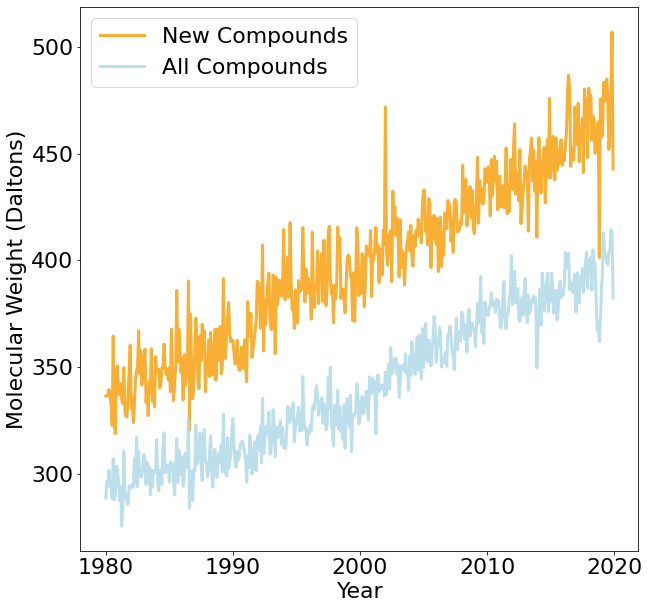

In [35]:
## Avg MA value per month

#Assembly values with standard deviation
plt.figure(figsize=(10,10))

plt.plot(np.arange(1980, 2020, 1/12), new_stats["mw"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

plt.plot(np.arange(1980, 2020, 1/12), full_stats["mw"]["mean"], color="lightblue",
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")

## Test distribution width of AssemblyGo MA & MW

Gage's idea - the narrower distribution is the better predictor of future trends

Data organization & algorithm
- Labels in full_df
- Mol files in Data/AssemblyValues/FullDatabase & NewDatabase
- Use label to load rdkit mol object, return molecular weight

In [37]:
print(full_df_old)

        Unnamed: 0    month  \
0                0  2003-01   
1                1  2003-01   
2                2  2003-01   
3                3  2003-01   
4                4  2003-01   
...            ...      ...   
468286       11801  2012-12   
468287       11802  2012-12   
468288       11803  2012-12   
468289       11804  2012-12   
468290       11805  2012-12   

                                                    inchi  ai          mw  
0                  InChI=1S/C6H5Cl/c7-6-4-2-1-3-5-6/h1-5H   4  112.007978  
1       InChI=1S/C4H8O2.C3H8O/c1-3-6-4(2)5;1-3(2)4/h3H...   3  148.109944  
2       InChI=1S/C31H46O2/c1-22(2)12-9-13-23(3)14-10-1...  18  450.349781  
3       InChI=1S/C29H32O13/c1-11-36-9-20-27(40-11)24(3...  28  588.184291  
4       InChI=1S/C12H22N4O11P2/c1-16(2,3)26-29(22,23)2...  26  460.076031  
...                                                   ...  ..         ...  
468286  InChI=1S/C43H39Cl3N6O4/c44-26-9-11-30(32(46)21...  63  808.209837  
468287  InChI=1S/C3

In [30]:
def get_MW(label):
    mol = Chem.MolFromMolFile("Data/AssemblyValues/FullDatabase/" + label + ".mol")
    return Descriptors.ExactMolWt(mol)

In [31]:
weights = []

for label in tqdm(list(full_df["label"])):
    weights.append(get_MW(label))

KeyError: 'label'

In [42]:
#Apply to full and new dataframes
tqdm.pandas()

full_df["month"] = full_df["label"].apply(get_month)
new_df["month"] = new_df["label"].apply(get_month)

full_df["MW"] = weights

full_df = full_df.dropna()
new_df = new_df.dropna()

print(full_df)


        Unnamed: 0           label  MA_assemblyGo    month          MW
0                0  1994-03_365031             13  1994-03  308.055529
1                1  1994-09_370717             11  1994-09  252.925366
2                2   2017-11_80436             22  2017-11  426.216809
3                3  2010-04_214306              9  2010-04  188.028500
4                4  2005-11_267327             12  2005-11  502.423340
...            ...             ...            ...      ...         ...
467872      467872  2018-01_433720             21  2018-01  458.134794
467873      467873  2016-12_420694             30  2016-12  584.150525
467874      467874  1997-05_238251              7  1997-05  522.573967
467875      467875  1993-03_283329             24  1993-03  474.263091
467876      467876  1982-10_184989             16  1982-10  318.112819

[466872 rows x 5 columns]


[  1  19  44  79  87 107  83  87  84  69  50  57  45  30  20  11  15  15
  13   6  13   6   6   4   4   3   5   3   3   1   1   1   1]
NormaltestResult(statistic=5.731301493661258, pvalue=0.05694606160279805)
Peaks: [5]
Widths: (array([7.5037594]), array([54.]), array([2.28571429]), array([9.78947368]))


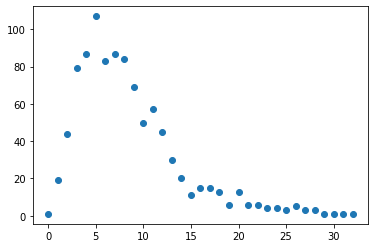

In [75]:
### Testing: get distribution stats for 1980-01
sub_df = full_df[full_df["month"] == "1980-01"]

values, counts = np.unique(sub_df["MA_assemblyGo"], return_counts = True)
print(counts)

# print(sub_df["MA_assemblyGo"].describe())
print(stats.normaltest(counts))

#Find peaks, then find widths
peaks, _ = find_peaks(counts, threshold=max(counts)/10)
# max_loc = np.where(max(counts))
# print(max_loc[0])
# print(max_loc.shape)
print("Peaks:", peaks)

widths = peak_widths(counts, peaks)
print("Widths:", widths)

# print("-----")
# print(sub_df["MW"].describe())
# print(stats.normaltest(sub_df["MW"]))

plt.scatter(np.arange(0, len(counts)), counts)



NormaltestResult(statistic=1022.3143890911133, pvalue=1.0168362579330784e-222)
Peaks: [  4  10  12  22  24  27  29  33  36  44  68  74  93 102 106 109 122 128
 133 141 146 157 201 210 229 236 274 296 332 336 380 397 401 427 464 517
 573 582 646]
Widths: (array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1.5, 1. , 1. , 1.5, 1. ,
       1.5, 1. , 1.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ]), array([3. , 1.5, 1.5, 1.5, 1.5, 1.5, 2. , 1.5, 2. , 1.5, 1.5, 2. , 2. ,
       2. , 1.5, 2. , 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]), array([  3.5,   9.5,  11.5,  21.5,  23.5,  26.5,  28.5,  32.5,  35. ,
        43.5,  67.5,  73. ,  92.5, 101.5, 105.5, 108. , 121.5, 127.5,
       132.5, 140.5, 145.5, 156.5, 200.5, 209.5, 228.5, 235.5, 273.5,
       295.5, 331.5, 335.5, 379.5, 396.5, 400.5, 426.5, 463.5, 516.5,
       572.5, 581.5, 645.5]),

(array([32., 60., 66., 71., 76., 90., 68., 75., 68., 57., 44., 54., 32.,
        27., 25., 15., 10., 17.,  9., 17., 12.,  7.,  7.,  4.,  4.,  4.,
         4.,  2.,  1.,  1.,  4.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.]),
 array([ 107.07349929,  127.62714076,  148.18078222,  168.73442369,
         189.28806516,  209.84170663,  230.3953481 ,  250.94898957,
         271.50263103,  292.0562725 ,  312.60991397,  333.16355544,
         353.71719691,  374.27083838,  394.82447984,  415.37812131,
         435.93176278,  456.48540425,  477.03904572,  497.59268719,
         518.14632865,  538.69997012,  559.25361159,  579.80725306,
         600.36089453,  620.914536  ,  641.46817746,  662.02181893,
         682.5754604 ,  703.12910187,  723.68274334,  744.23638481,
         764.79002627,  785.34366774,  805.89730921,  826.45095068,
         847.00459215,  867.55823362,  888.11187508,  908.66551655,
         929.21915802,  949.77279949

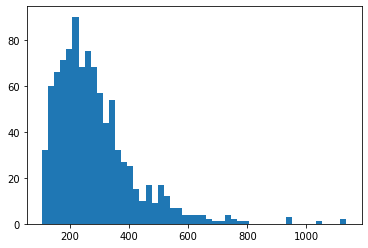

In [79]:
### Testing: get distribution stats for 1980-01
sub_df = full_df[full_df["month"] == "1980-01"]

values, counts = np.unique(sub_df["MW"], return_counts = True)

# print(sub_df["MA_assemblyGo"].describe())
print(stats.normaltest(counts))

#Find peaks, then find widths
peaks, _ = find_peaks(counts, threshold=max(counts)/10)
# max_loc = np.where(max(counts))
# print(max_loc[0])
# print(max_loc.shape)
print("Peaks:", peaks)

widths = peak_widths(counts, peaks)
print("Widths:", widths)

# print("-----")
# print(sub_df["MW"].describe())
# print(stats.normaltest(sub_df["MW"]))

plt.hist(sub_df["MW"], bins=50)



(array([0.31346351, 0.68139774, 0.8684481 , 0.93833505, 0.97327852,
        0.98561151, 0.9938335 , 0.9938335 , 0.99691675, 1.        ]),
 array([ 107.07349929,  209.84170663,  312.60991397,  415.37812131,
         518.14632865,  620.914536  ,  723.68274334,  826.45095068,
         929.21915802, 1031.98736536, 1134.7555727 ]),
 <BarContainer object of 10 artists>)

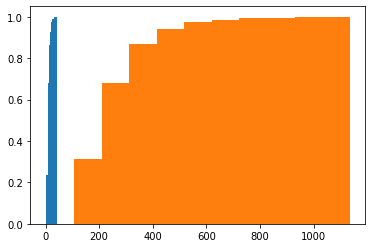

In [89]:
stats.ks_2samp(list(sub_df["MA_assemblyGo"].values), list(sub_df["MW"].values), alternative="greater")

plt.hist(sub_df["MA_assemblyGo"], density=True, cumulative=True)
plt.hist(sub_df["MW"], density=True, cumulative=True)

In [91]:
#Try normalizing data
from sklearn import preprocessing

MAs = preprocessing.normalize([sub_df["MA_assemblyGo"]])

MWs = preprocessing.normalize([sub_df["MW"]])


[[ 0.03539701  0.02781194  0.02781194  0.03539701  0.03539701  0.05056716
   0.01517015  0.02275522  0.02275522  0.02022687  0.01769851  0.01011343
   0.02528358  0.03286866  0.01264179  0.03792537  0.02022687  0.01517015
   0.03539701  0.01517015  0.02022687  0.05056716  0.0303403   0.05309552
   0.01517015  0.02022687  0.01264179  0.0303403   0.02275522  0.01769851
  -0.00252836  0.02781194  0.01769851  0.09860597  0.06573731  0.02275522
   0.02022687  0.03286866  0.02528358  0.03792537  0.04298209  0.01517015
   0.02781194  0.01769851  0.02275522  0.05815224  0.02022687  0.04298209
   0.02275522  0.02022687  0.08343582  0.01769851  0.01517015  0.03286866
   0.02022687  0.04298209  0.01011343  0.02781194  0.0303403   0.04298209
   0.06573731  0.01011343  0.0303403   0.0303403   0.01517015  0.03286866
   0.02275522  0.01769851  0.01769851  0.01769851  0.01769851  0.02022687
   0.04045373  0.03286866  0.03539701  0.0303403   0.01517015  0.02528358
   0.02022687  0.02022687  0.01517015 

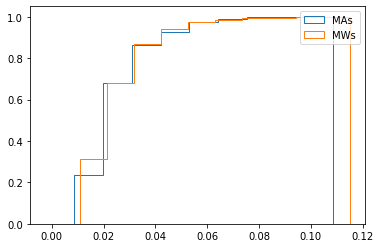

In [97]:
plt.hist(MAs[0], density=True, histtype="step", cumulative=True, label="MAs")
plt.hist(MWs[0], density=True, histtype="step", cumulative=True, label="MWs")

plt.legend()

In [ ]:
### GET PDF - THIS IS THE HOW QUICK THE DISTRIBUTION CHANGES (AND THEREFORE IS A MEASURE OF NARROWNESS, 
# NARROWER DISTRIBUTIONS CHANGE QUICKER)

## Predict MW increases in the future 

Using same AutoETS code for MA

Theory - the smaller distribution in the future (e.g., size of 95% confidence interval) will be helpful in determining which of the two is narrower

In [44]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, SimpleExponentialSmoothing

In [45]:
full_df_mw = pd.read_csv("Data/AssemblyValues/fullCpds_AssemblyValues.csv")
new_df_old = pd.read_csv("Data/AssemblyValues/newCpds_AssemblyValues.csv")
print(full_df_old.head())
print("----------------------------------")
print(new_df_old.head())

   Unnamed: 0    month                                              inchi  ai  \
0           0  2003-01             InChI=1S/C6H5Cl/c7-6-4-2-1-3-5-6/h1-5H   4   
1           1  2003-01  InChI=1S/C4H8O2.C3H8O/c1-3-6-4(2)5;1-3(2)4/h3H...   3   
2           2  2003-01  InChI=1S/C31H46O2/c1-22(2)12-9-13-23(3)14-10-1...  18   
3           3  2003-01  InChI=1S/C29H32O13/c1-11-36-9-20-27(40-11)24(3...  28   
4           4  2003-01  InChI=1S/C12H22N4O11P2/c1-16(2,3)26-29(22,23)2...  26   

           mw  
0  112.007978  
1  148.109944  
2  450.349781  
3  588.184291  
4  460.076031  
----------------------------------
   Unnamed: 0    month                                              inchi  ai  \
0           0  1996-01  InChI=1S/C12H19NO2/c1-3-4-5-6-8-11(2)15-12(14)...  11   
1           1  1996-01  InChI=1S/C14H10ClN3S2/c15-11-4-2-1-3-10(11)13-...  18   
2           2  1996-01  InChI=1S/C8H10N2O2/c9-7-3-1-6(2-4-7)5-12-8(10)...   9   
3           3  1996-01  InChI=1S/C13H21NO2/c1-10(9-14(3)4)

In [48]:
## Get dataframes with dates (necessary for the AutoARIMA model)
full_df_mw = full_df_old.groupby(["month"]).agg({"mw":["mean","std"]}).reset_index()

new_df_mw = new_df_old.groupby(["month"]).agg({"mw":["mean","std"]}).reset_index()

print(full_df_mw)

       month          mw            
                    mean         std
0    1980-01  288.903786  146.598677
1    1980-02  296.786454  146.024411
2    1980-03  294.921734  140.442600
3    1980-04  301.813923  144.990354
4    1980-05  294.044223  145.079729
..       ...         ...         ...
475  2019-08  404.242385  195.509793
476  2019-09  404.686906  218.538348
477  2019-10  414.404896  201.612743
478  2019-11  413.057041  246.032313
479  2019-12  382.471763  198.892265

[480 rows x 3 columns]


In [50]:
# Turn dates into ordinal values (for training purposes)
months = pd.Series(full_df_mw["month"]) + "-01"

datetimes = []
for date in months:
    datetimes.append(dt.strptime(date, '%Y-%m-%d').date())

In [51]:
#Ensure proper dataframe setup (remove groupby association, change month to datetimes)
full_df_MW = pd.DataFrame()
full_df_MW["ds"] = datetimes
full_df_MW["y"] = full_df_mw["mw"]["mean"]
full_df_MW["unique_id"] = [0] * len(full_df_MW)
full_df_MW = full_df_MW.set_index("unique_id")
full_df_MW.reset_index()
print(full_df_MW)

print("----------")

new_df_MW = pd.DataFrame()
new_df_MW["ds"] = datetimes
new_df_MW["y"] = new_df_mw["mw"]["mean"]
new_df_MW["unique_id"] = [0] * len(new_df_MW)
new_df_MW = new_df_MW.set_index("unique_id")
new_df_MW.reset_index()

print(new_df_MW)


                   ds           y
unique_id                        
0          1980-01-01  288.903786
0          1980-02-01  296.786454
0          1980-03-01  294.921734
0          1980-04-01  301.813923
0          1980-05-01  294.044223
...               ...         ...
0          2019-08-01  404.242385
0          2019-09-01  404.686906
0          2019-10-01  414.404896
0          2019-11-01  413.057041
0          2019-12-01  382.471763

[480 rows x 2 columns]
----------
                   ds           y
unique_id                        
0          1980-01-01  336.580176
0          1980-02-01  337.134343
0          1980-03-01  336.756317
0          1980-04-01  339.631414
0          1980-05-01  336.565682
...               ...         ...
0          2019-08-01  451.904218
0          2019-09-01  458.872211
0          2019-10-01  480.513055
0          2019-11-01  506.845204
0          2019-12-01  442.764811

[480 rows x 2 columns]


In [52]:
## Set up training/test dataframes
Y_trainNEW_df = new_df_MW[:n_train]
Y_testNEW_df = new_df_MW[n_train:]

Y_trainFULL_df = full_df_MW[:n_train]
Y_testFULL_df = full_df_MW[n_train:]

print(Y_trainNEW_df.head())
print("-----")
print(Y_trainFULL_df.head())

                   ds           y
unique_id                        
0          1980-01-01  336.580176
0          1980-02-01  337.134343
0          1980-03-01  336.756317
0          1980-04-01  339.631414
0          1980-05-01  336.565682
-----
                   ds           y
unique_id                        
0          1980-01-01  288.903786
0          1980-02-01  296.786454
0          1980-03-01  294.921734
0          1980-04-01  301.813923
0          1980-05-01  294.044223


In [53]:
## Set up model parameters

season_length = 12 #example is built on 12-month-long cyclical data, but this might work for me too...
horizon = len(Y_testNEW_df)

models = [
AutoARIMA(season_length = season_length),
AutoETS(season_length = season_length, model='ZZZ'),
SimpleExponentialSmoothing(0.99)
]

modelNEW = StatsForecast(
df=Y_trainNEW_df,
models=models,
freq='M',
n_jobs=-1)

modelFULL = StatsForecast(
df=Y_trainFULL_df,
models=models,
freq='M',
n_jobs=-1)

In [54]:
## NOTE: takes ~30 seconds the first time

# Addition to horizon is the number of months in the future (120 corresponds to 10 years)

Y_hatNEW_df = modelNEW.forecast(horizon + 120, level=[95]).reset_index()
Y_hatNEW_df.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95,AutoETS,AutoETS-lo-95,AutoETS-hi-95,SES
0,0,2007-12-31,417.687653,392.696350,442.678955,420.473694,395.809662,445.137695,418.644958
1,0,2008-01-31,417.687653,392.483612,442.891724,420.727417,396.013824,445.440979,418.644958
2,0,2008-02-29,417.687653,392.272614,443.102692,420.981140,396.217926,445.744354,418.644958
3,0,2008-03-31,417.687653,392.063385,443.311951,421.234863,396.421967,446.047760,418.644958
4,0,2008-04-30,417.687653,391.855835,443.519501,421.488586,396.625946,446.351227,418.644958


In [55]:
Y_hatFULL_df = modelFULL.forecast(horizon + 120, level=[95]).reset_index()
Y_hatFULL_df.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95,AutoETS,AutoETS-lo-95,AutoETS-hi-95,SES
0,0,2007-12-31,362.12085,346.046936,378.194733,363.313232,347.479858,379.146606,362.494415
1,0,2008-01-31,362.12085,345.849091,378.392609,363.523987,347.621826,379.426117,362.494415
2,0,2008-02-29,362.12085,345.653595,378.588104,363.734711,347.763977,379.705475,362.494415
3,0,2008-03-31,362.12085,345.460388,378.781311,363.945465,347.906250,379.984711,362.494415
4,0,2008-04-30,362.12085,345.269379,378.972290,364.156219,348.048645,380.263763,362.494415


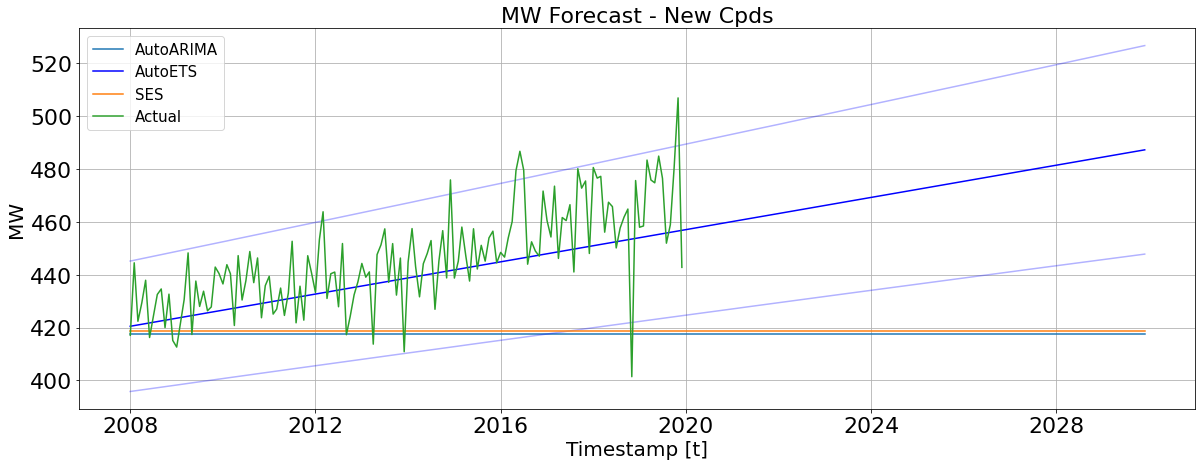

In [56]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["AutoARIMA"], label="AutoARIMA")
plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["AutoETS"], label="AutoETS", color="blue")
plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["AutoETS-lo-95"], color="blue", alpha=0.3)
plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["AutoETS-hi-95"], color="blue", alpha=0.3)

plt.plot(Y_hatNEW_df["ds"], Y_hatNEW_df["SES"], label="SES")

plt.plot(Y_testNEW_df["ds"], Y_testNEW_df["y"], label="Actual")

#plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
# plot_df[['y', 'AutoARIMA', 'ETS']].plot(ax=ax, linewidth=2)

ax.set_title('MW Forecast - New Cpds', fontsize=22)
ax.set_ylabel('MW', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

Text(0, 0.5, 'Molecular Weight (Daltons)')

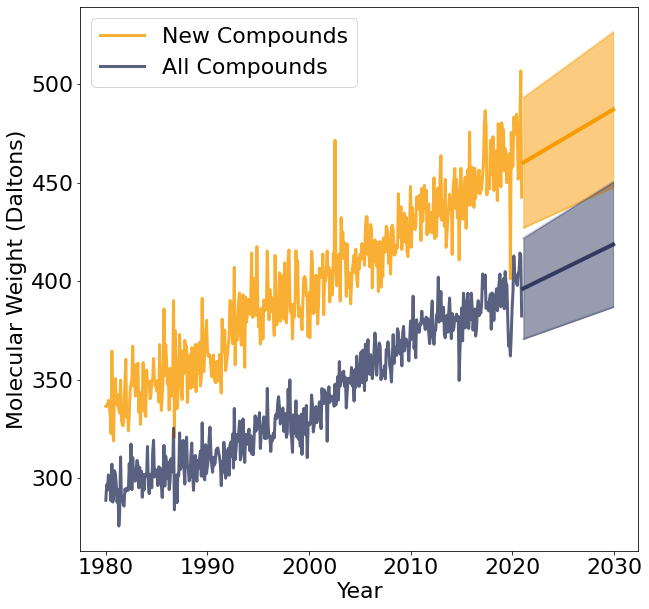

In [57]:
#Assembly values with standard deviation & predicted values (from autoETS)
plt.figure(figsize=(10,10))

new_color = "#f89b00"
full_color= "#313a61"
xs = pd.date_range(start = "1980-01-01", end = "2020-12-01", periods = 480).to_pydatetime().tolist()

plt.plot(xs, new_stats["mw"]["mean"], color=new_color,
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

## cutoff is the prediction level (number of months in the future, minus 13 - not entirely sure why this works)
cutoff = 120 - 13

#New cpd prediction
plt.plot(list(Y_hatNEW_df["ds"])[-cutoff:], list(Y_hatNEW_df["AutoETS"])[-cutoff:], color=new_color,
    linewidth=4)
plt.plot(list(Y_hatNEW_df["ds"])[-cutoff:], list(Y_hatNEW_df["AutoETS-lo-95"])[-cutoff:], color=new_color,
    linewidth=2, alpha=0.25)
plt.plot(list(Y_hatNEW_df["ds"])[-cutoff:], list(Y_hatNEW_df["AutoETS-hi-95"])[-cutoff:], color=new_color,
    linewidth=2, alpha=0.25)

plt.fill_between(list(Y_hatNEW_df["ds"])[-cutoff:], list(Y_hatNEW_df["AutoETS-lo-95"])[-cutoff:], 
    list(Y_hatNEW_df["AutoETS-hi-95"])[-cutoff:], color=new_color, alpha=0.5)


#Full cpd plotting
plt.plot(xs, full_stats["mw"]["mean"], color=full_color,
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

#Full cpd prediction
plt.plot(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS"])[-cutoff:], color=full_color,
    linewidth=4)
plt.plot(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS-lo-95"])[-cutoff:], color=full_color,
    linewidth=2, alpha=0.25)
plt.plot(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS-hi-95"])[-cutoff:], color=full_color,
    linewidth=2, alpha=0.25)

plt.fill_between(list(Y_hatFULL_df["ds"])[-cutoff:], list(Y_hatFULL_df["AutoETS-lo-95"])[-cutoff:], 
    list(Y_hatFULL_df["AutoETS-hi-95"])[-cutoff:], color=full_color, alpha=0.5)

plt.legend()
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")

In [63]:
### Percent coverage at last predicted timestep - should be comparable with MA

final_mw_low = list(Y_hatFULL_df["AutoETS-lo-95"])[-1]
final_mw_high = list(Y_hatFULL_df["AutoETS-hi-95"])[-1]
final_mw_predicted = list(Y_hatFULL_df["AutoETS"])[-1]

print(final_mw_high)
print(final_mw_predicted)

mw_percent = final_mw_predicted / final_mw_high
print("Percent coverage:", (1 - mw_percent) * 100 )


450.4697570800781
418.7395324707031
Percent coverage: 7.043807960616199


## MA with Standard Deviation

And other tests!

Text(0, 0.5, 'Assembly Index')

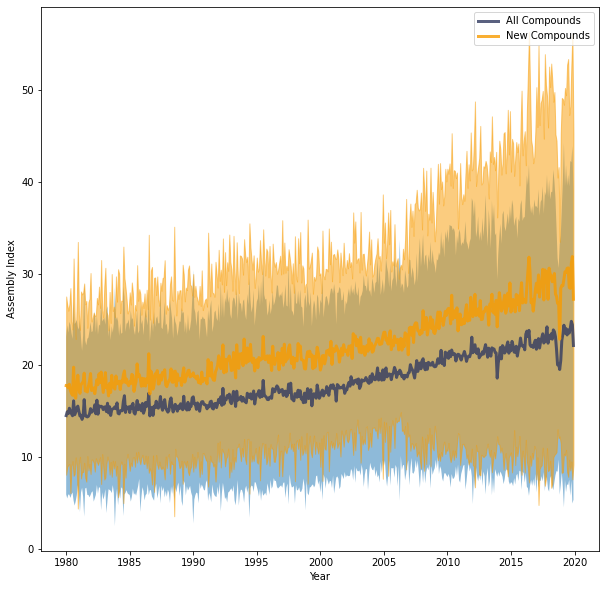

In [11]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))

# plt.errorbar(np.arange(1980, 2019, 1/12), full_month_avgs, yerr=full_month_stds, color="#313a61",
#             elinewidth=1, linewidth=3, markersize=10, alpha=0.8, label="All Compounds")
plt.plot(np.arange(1980, 2020, 1/12), full_stats["ai"]["mean"], color="#313a61",
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")
plt.fill_between(np.arange(1980, 2020, 1/12), full_stats["ai"]["mean"] - full_stats["ai"]["std"], 
                full_stats["ai"]["mean"] + full_stats["ai"]["std"], alpha=0.5)

# # plt.errorbar(np.arange(1980, 2019, 1/12), new_month_avgs, yerr=new_month_stds, color="#f89b00",
# #             elinewidth=1, linewidth=3, markersize=10, alpha=0.4, label="New Compounds")

plt.plot(np.arange(1980, 2020, 1/12), new_stats["ai"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")
plt.fill_between(np.arange(1980, 2020, 1/12), new_stats["ai"]["mean"] - new_stats["ai"]["std"], 
                new_stats["ai"]["mean"] + new_stats["ai"]["std"], alpha=0.5, color="#f89b00")

#plt.axes().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")

Text(0, 0.5, 'Assembly Index')

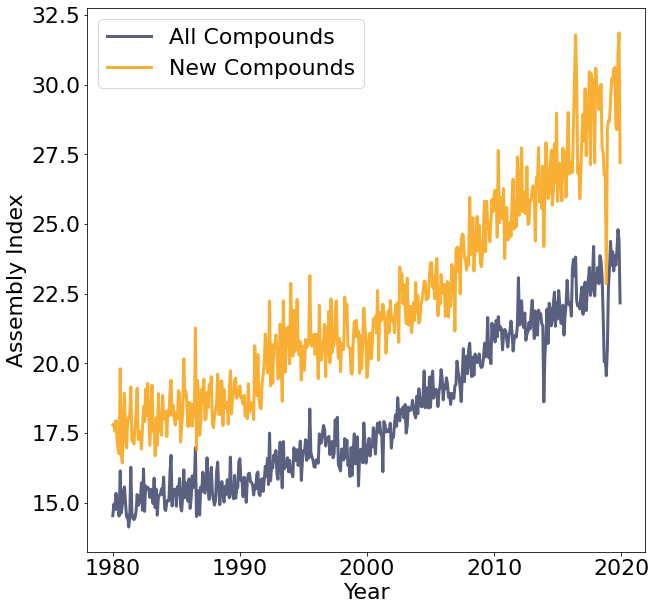

In [22]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))

plt.plot(np.arange(1980, 2020, 1/12), full_stats["ai"]["mean"], color="#313a61",
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

plt.plot(np.arange(1980, 2020, 1/12), new_stats["ai"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")

## Expected Assembly Values

Based on linear regression of a large assortment of assembly values (in ~/Lab/AssemblyValues/)

x = 0.0456; b = 2.4826

In [27]:
#Add a "expected assembly value" column to each results dataframe
full_stats["ExpectedMA"] = 2.4826 + 0.0456*full_stats["mw"]["mean"]
new_stats["ExpectedMA"] = 2.4826 + 0.0456*new_stats["mw"]["mean"]

Text(0, 0.5, 'Assembly Index')

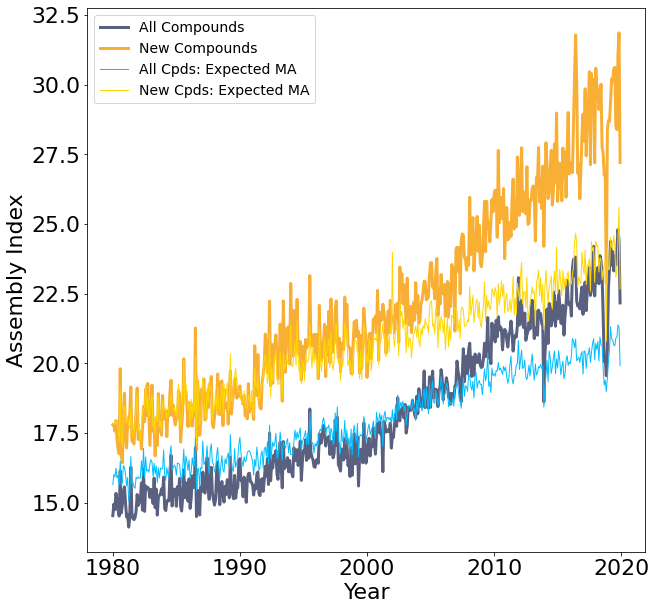

In [34]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))

xs = np.arange(1980, 2020, 1/12)

#Average assembly Values
plt.plot(xs, full_stats["ai"]["mean"], color="#313a61",
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

plt.plot(xs, new_stats["ai"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

#Expected MA values
plt.plot(xs, full_stats["ExpectedMA"], color="deepskyblue", linewidth=1, label="All Cpds: Expected MA")
plt.plot(xs, new_stats["ExpectedMA"], color="gold", linewidth=1, label="New Cpds: Expected MA")

plt.legend(prop={"size":14})
plt.xlabel("Year")
plt.ylabel("Assembly Index")

# Stats on assembly distributions

Perform statistics to test:

- Normality of distributions
- Significance of difference between new & full MA distributions

In [18]:
#Get lists of all MA values for each month
full_MA = full_df.groupby("month").agg({"ai":list})
new_MA = new_df.groupby("month").agg({"ai":list})

print(new_MA)

                                                        ai
month                                                     
1980-01  [10, 14, 18, 7, 8, 9, 17, 5, 8, 7, 13, 12, 11,...
1980-02  [9, 9, 7, 30, 5, 14, 6, 9, 8, 22, 8, 21, 10, 2...
1980-03  [19, 10, 23, 12, 11, 14, 6, 8, 10, 15, 15, 19,...
1980-04  [34, 35, 24, 22, 17, 6, 9, 9, 11, 13, 12, 6, 5...
1980-05  [8, 18, 5, 6, 31, 7, 8, 12, 9, 21, 17, 18, 13,...
...                                                    ...
2019-08  [42, 61, 76, 21, 17, 30, 26, 17, 18, 24, 27, 2...
2019-09  [22, 34, 29, 29, 32, 33, 21, 18, 27, 29, 20, 1...
2019-10  [14, 14, 13, 24, 19, 21, 16, 26, 22, 23, 11, 6...
2019-11  [15, 34, 73, 28, 56, 61, 28, 28, 29, 14, 29, 2...
2019-12  [7, 28, 49, 28, 16, 15, 21, 15, 14, 12, 13, 31...

[480 rows x 1 columns]


## Test for Normality

Test each distribution for normal distribution

Text(0.5, 1.0, 'New Cpds, 1980-01')

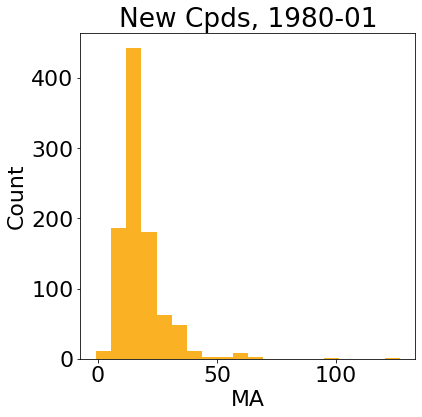

In [38]:
#Plot 1980 & 2019 for both datasets
plt.figure(figsize=(6,6))

plt.hist(new_MA.loc["1980-01"]["ai"], bins=20, color=colors["new"])

plt.xlabel("MA")
plt.ylabel("Count")
plt.title("New Cpds, 1980-01")

In [ ]:
for month, row in new_MA.iterrows():
    print(month)

    print(stats.shapiro(row["ai"]))
    print()


## Test difference between distributions

Is there a significant difference between full and new MA distributions within each month?

In [42]:
#Mann-Whitney U rank test (non-parametric)
months = build_month_increments(1980, 2019)

for month in months[0:12]:
    print(stats.mannwhitneyu(full_MA.loc[month]["ai"], new_MA.loc[month]["ai"]))

MannwhitneyuResult(statistic=341046.5, pvalue=4.511971652068771e-25)
MannwhitneyuResult(statistic=346974.5, pvalue=1.4222405157820336e-21)
MannwhitneyuResult(statistic=356178.5, pvalue=5.402311037826035e-21)
MannwhitneyuResult(statistic=348704.0, pvalue=6.434678202030446e-20)
MannwhitneyuResult(statistic=377746.5, pvalue=3.719511629092984e-12)
MannwhitneyuResult(statistic=376241.0, pvalue=5.628169663383528e-17)
MannwhitneyuResult(statistic=353232.0, pvalue=4.19446663391659e-19)
MannwhitneyuResult(statistic=359116.0, pvalue=8.40243821615334e-21)
MannwhitneyuResult(statistic=362088.5, pvalue=4.6886455470052366e-17)
MannwhitneyuResult(statistic=361537.5, pvalue=2.1541743396872751e-16)
MannwhitneyuResult(statistic=367975.5, pvalue=2.295500637851385e-17)
MannwhitneyuResult(statistic=385028.5, pvalue=1.7137172972616657e-14)


In [ ]:
#z-test (assumes normality, but from https://www.researchgate.net/post/Hello-could-you-please-share-with-me-the-formula-of-Mann-Whitney-U-Test-critical-values-for-large-samples-n100, at large values of n, parametric tests can be used)
months = build_month_increments(1980, 2019)

for month in months:
    #Null hypothesis - no difference between the distributions (therefore, if p-value is <0.5, then the distributions are different)
    zstat, pval = ztest(full_MA.loc[month]["ai"], new_MA.loc[month]["ai"], value=0) 
    if pval > 0.05:
        print(month, "is not significantly different")
    else:
        print(month + "," +str(zstat) + "," + str(pval))

### Wasserstein Distancxe

Find monthly & average wasserstein distance between each distribution

In [61]:
months = build_month_increments(1980, 2019)
w_dist = []

for month in months:
    w_dist.append(stats.wasserstein_distance(full_MA.loc[month]["ai"], new_MA.loc[month]["ai"]))

print("Average Wasserstein distance:", np.mean(w_dist))

Average Wasserstein distance: 4.115881048100523


Text(0, 0.5, 'Wasserstein Distance')

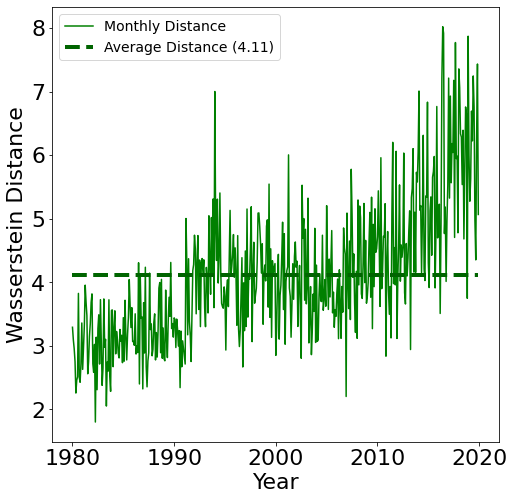

In [75]:
plt.figure(figsize=(8,8))

xs = np.arange(1980, 2020, 1/12)

plt.plot(xs, w_dist, color="green", label="Monthly Distance")
plt.plot(xs, [np.mean(w_dist)]*len(xs), color="darkgreen", linestyle="--", linewidth=4, label="Average Distance (4.11)")

plt.legend(prop={"size":14})
plt.xlabel("Year")
plt.ylabel("Wasserstein Distance")

# Changing Compounds Assemblies

Analyze the assembly values of fast-changing (min & max percentiles) compounds

Sets to analyze:
1. Compounds in 99.99th percentile
2. Changing compounds, 99.99th percentile (maxPercentile_0.01_99.99*)
3. Changing compounds, below 0.01st percentile (minPercentile_0.01_99.99*)
4. Changing compounds, 99.9th percentile (maxPercentile_0.1_99.9*)
5. Changing compounds, below 0.1st percentile (minPercentile_0.1_99.9*) 

In [4]:
## Matplotlib defaults ##
colors = {"1980": "#aa0f35", 
         "1985": "#fdc799",
         "1990": "#abdbfc",
         "1995": "#a0a75c",
         "2000": "#603734",
         "2005": "#009ecb",
         "2010": "#430057",
         "2015": "#f89b00"}

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rcParams.update({'font.size': 22})

### Compounds in 99.99th percentile 

Plot & analyze the most connected compounds in SureChemBL

------  (2015, 2019) -----
DescribeResult(nobs=722, minmax=(1, 119), mean=15.637119113573407, variance=256.75579085680477, skewness=3.308937717875287, kurtosis=12.829833350312803)
------  (2010, 2014) -----
DescribeResult(nobs=695, minmax=(1, 119), mean=15.751079136690647, variance=284.97973586548625, skewness=3.264398959689537, kurtosis=11.761944878282671)
------  (2005, 2009) -----
DescribeResult(nobs=540, minmax=(1, 119), mean=17.15, variance=354.5655844155844, skewness=2.748878893799469, kurtosis=7.721047532280789)
------  (2000, 2004) -----
DescribeResult(nobs=265, minmax=(1, 100), mean=16.60377358490566, variance=346.93710691823895, skewness=2.4396828094647396, kurtosis=5.448874109651744)
------  (1995, 1999) -----
DescribeResult(nobs=163, minmax=(2, 87), mean=15.50920245398773, variance=322.7082481254261, skewness=2.2988947899026977, kurtosis=4.296780402120956)
------  (1990, 1994) -----
DescribeResult(nobs=126, minmax=(3, 87), mean=16.73015873015873, variance=393.7986031746031,

Text(0, 0.5, 'Compound Density')

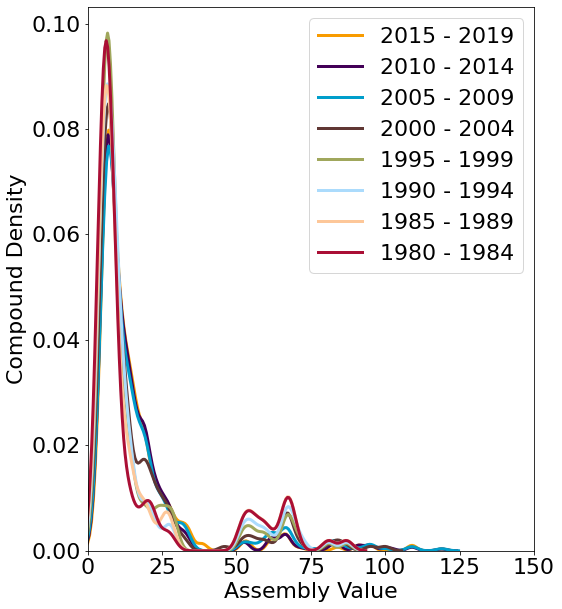

In [48]:
pairs = [(1980, 1984), (1985,1989), (1990,1994), (1995,1999), (2000,2004), (2005,2009), (2010,2014), (2015,2019)]

full_ais = []

plt.figure(figsize=(8,10))

for pair in reversed(pairs):
    print("------ ", pair, "-----")
    start = pair[0]
    stop = pair[1]
    ids = pickle.load(file=open("Data/Cpd_Data/ids_above99_99percentile" + str(start) + "_" + 
                                str(stop) + "cpdData_assembly.p", "rb"))
    
    ais = []
    for cpd in ids:
        ais.append(cpd["ai"])
        
    #Remove -1s
    ais = [x for x in ais if x != -1]
    full_ais.append(ais)

    print(stats.describe(ais))
    
    #plt.hist(ais, bins=100, color=colors[str(start)], label= str(start) + " - " + str(stop))
    sns.kdeplot(ais, bw_method=0.1, color=colors[str(start)], label= str(start) + " - " + str(stop), linewidth=3)

plt.legend()
plt.xlim(0,150)
plt.xlabel("Assembly Value")
plt.ylabel("Compound Density")

In [54]:
combos = itertools.combinations(range(0,len(full_ais)), 2)
for combo in combos:
    print(combo)
    print(stats.ks_2samp(full_ais[combo[0]], full_ais[combo[1]]))
    print(stats.anderson_ksamp([full_ais[combo[0]], full_ais[combo[1]]]))
    print("Wasserstein Distance:", stats.wasserstein_distance(full_ais[combo[0]], full_ais[combo[1]]))
    print()

(0, 1)
KstestResult(statistic=0.011891428685306602, pvalue=0.9999999977077801)
Anderson_ksampResult(statistic=-1.0699860338119844, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 0.5383247972259305

(0, 2)
KstestResult(statistic=0.03345644813788858, pvalue=0.864307761582229)
Anderson_ksampResult(statistic=-0.7580090187166283, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.5986713860675081

(0, 3)
KstestResult(statistic=0.07503789264621336, pvalue=0.21189782394499013)
Anderson_ksampResult(statistic=2.095567746527271, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.044571432106303426)
Wasserstein Distance: 2.4402341504207357

(0, 4)
KstestResult(statistic=0.15266896657206463, pvalue=0.00355205398259939)
Anderson_ksampResult(statistic=7.680779381202069, critical_values=array([0.325, 1.226, 1.961,

c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value capped: true value larger than 0.25
  """
c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value floored: true value smaller than 0.001
  """


Anderson_ksampResult(statistic=9.969150247135532, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
Wasserstein Distance: 4.8081519663993895

(3, 4)
KstestResult(statistic=0.07952309295057298, pvalue=0.5130898912449378)
Anderson_ksampResult(statistic=0.4417356012385059, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.21880182947808205)
Wasserstein Distance: 1.445630281282555

(3, 5)
KstestResult(statistic=0.0746031746031746, pvalue=0.6925072704114961)
Anderson_ksampResult(statistic=0.08146284297910673, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 2.2620545073375258

(3, 6)
KstestResult(statistic=0.10302672955974843, pvalue=0.4094223190343369)
Anderson_ksampResult(statistic=0.4713304271827982, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.21247405604335284)
Wasserstein

### Changing compounds, 99.9th percentile 

------  (2015, 2019) -----
DescribeResult(nobs=255, minmax=(2, 72), mean=10.011764705882353, variance=70.38962482630848, skewness=3.9867883140560094, kurtosis=20.504278861694107)

------  (2010, 2014) -----
DescribeResult(nobs=192, minmax=(2, 72), mean=9.916666666666666, variance=75.68935427574172, skewness=4.255366022937834, kurtosis=22.321515447802124)

------  (2005, 2009) -----
DescribeResult(nobs=44, minmax=(3, 59), mean=11.272727272727273, variance=159.69133192389006, skewness=2.8373976748006977, kurtosis=7.087474216438332)

------  (2000, 2004) -----
DescribeResult(nobs=11, minmax=(5, 28), mean=10.272727272727273, variance=41.41818181818182, skewness=2.0420616823932276, kurtosis=3.4622930639371434)

------  (1995, 1999) -----
DescribeResult(nobs=143, minmax=(2, 72), mean=10.23076923076923, variance=94.27735644637053, skewness=4.001581217375285, kurtosis=18.41325504799777)

------  (1990, 1994) -----
DescribeResult(nobs=193, minmax=(2, 72), mean=9.963730569948186, variance=76.587

Text(0, 0.5, 'Compound Density')

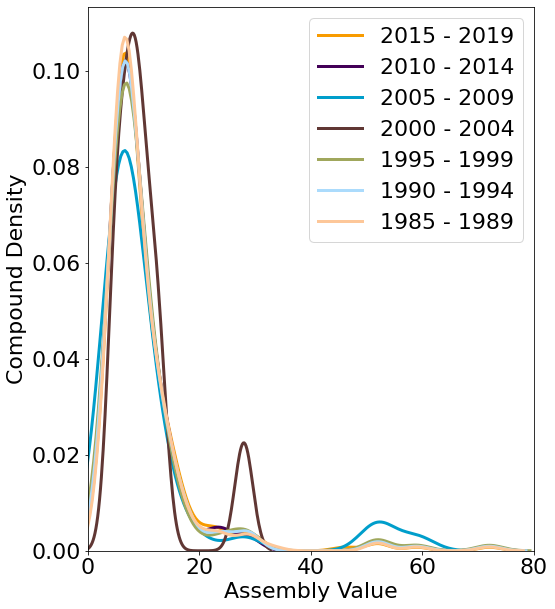

In [49]:
pairs = [(1985,1989), (1990,1994), (1995,1999), (2000,2004), (2005,2009), (2010,2014), (2015,2019)]

full_ais = []

plt.figure(figsize=(8,10))

for pair in reversed(pairs):
    print("------ ", pair, "-----")
    start = pair[0]
    stop = pair[1]
    ids = pickle.load(file=open("Data/Cpd_Data/ids_change_maxPercentile_0.1_99.9_" + str(start-1) + "_" + 
                                str(stop) + "cpdData_assembly.p", "rb"))
    
    ais = []
    for cpd in ids:
        ais.append(cpd["ai"])
        
    #Remove -1s
    ais = [x for x in ais if x != -1]
    full_ais.append(ais)

    print(stats.describe(ais))
    print()
    
    #plt.hist(ais, bins=100, color=colors[str(start)], alpha=0.8, label= str(start-1) + " - " + str(stop))
    sns.kdeplot(ais, bw_method=0.25, color=colors[str(start)], label= str(start) + " - " + str(stop), linewidth=3)
    

plt.legend()
plt.xlim(0,80)
plt.xlabel("Assembly Value")
plt.ylabel("Compound Density")

In [56]:
combos = itertools.combinations(range(0,len(full_ais)), 2)
for combo in combos:
    print(combo)
    print(stats.ks_2samp(full_ais[combo[0]], full_ais[combo[1]]))
    print(stats.anderson_ksamp([full_ais[combo[0]], full_ais[combo[1]]]))
    print("Wasserstein Distance:", stats.wasserstein_distance(full_ais[combo[0]], full_ais[combo[1]]))
    print()

(0, 1)
KstestResult(statistic=0.01997549019607843, pvalue=0.9999999995237022)
Anderson_ksampResult(statistic=-1.2325645468887758, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 0.2848039215686279

(0, 2)
KstestResult(statistic=0.08360071301247772, pvalue=0.9325351708624212)
Anderson_ksampResult(statistic=-0.49182366723549, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 2.154545454545455

(0, 3)
KstestResult(statistic=0.22923351158645278, pvalue=0.5602536950607762)
Anderson_ksampResult(statistic=-0.7006021084284263, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.7283422459893059

(0, 4)
KstestResult(statistic=0.02243246949129302, pvalue=0.9999999981044085)
Anderson_ksampResult(statistic=-1.2121593830680966, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.

c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value capped: true value larger than 0.25
  """


### Changing compounds, below 0.1st percentile 


------  (2015, 2019) -----
DescribeResult(nobs=14, minmax=(5, 23), mean=9.214285714285714, variance=19.719780219780223, skewness=2.2753652312810235, kurtosis=4.823006522592599)

------  (2010, 2014) -----
DescribeResult(nobs=33, minmax=(5, 23), mean=8.181818181818182, variance=11.090909090909088, skewness=2.7821910406362513, kurtosis=9.941764226686384)

------  (2005, 2009) -----
DescribeResult(nobs=151, minmax=(3, 53), mean=9.655629139072847, variance=36.84061810154526, skewness=3.627597139606427, kurtosis=18.859142589807984)

------  (2000, 2004) -----
DescribeResult(nobs=389, minmax=(3, 81), mean=10.352185089974293, variance=39.69265629555031, skewness=4.987640846788539, kurtosis=45.03610802378697)

------  (1995, 1999) -----
DescribeResult(nobs=216, minmax=(3, 53), mean=9.787037037037036, variance=32.43815676141257, skewness=3.3281999121769847, kurtosis=17.82198377577295)

------  (1990, 1994) -----
DescribeResult(nobs=434, minmax=(2, 81), mean=10.264976958525345, variance=42.84186

Text(0, 0.5, 'Compound Density')

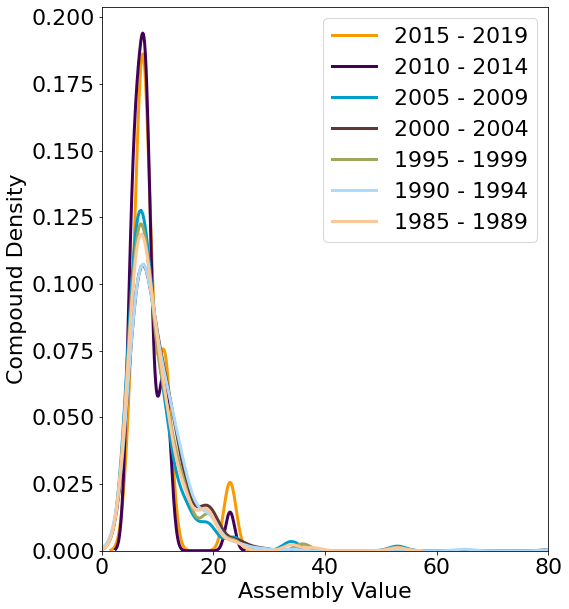

In [50]:
pairs = [(1985,1989), (1990,1994), (1995,1999), (2000,2004), (2005,2009), (2010,2014), (2015,2019)]

full_ais = []

plt.figure(figsize=(8,10))

for pair in reversed(pairs):
    print("------ ", pair, "-----")
    start = pair[0]
    stop = pair[1]
    ids = pickle.load(file=open("Data/Cpd_Data/ids_change_minPercentile_0.1_99.9_" + str(start-1) + "_" + 
                                str(stop) + "cpdData_assembly.p", "rb"))
    
    ais = []
    for cpd in ids:
        ais.append(cpd["ai"])
        
    #Remove -1s
    ais = [x for x in ais if x != -1]
    full_ais.append(ais)

    print(stats.describe(ais))
    print()
    
    #plt.hist(ais, bins=100, color=colors[str(start)], alpha=0.8, label= str(start-1) + " - " + str(stop))
    sns.kdeplot(ais, bw_method=0.25, color=colors[str(start)], label= str(start) + " - " + str(stop), linewidth=3)
    

plt.legend()
plt.xlim(0,80)
plt.xlabel("Assembly Value")
plt.ylabel("Compound Density")

In [58]:
combos = itertools.combinations(range(0,len(full_ais)), 2)
for combo in combos:
    print(combo)
    print(stats.ks_2samp(full_ais[combo[0]], full_ais[combo[1]]))
    print(stats.anderson_ksamp([full_ais[combo[0]], full_ais[combo[1]]]))
    print("Wasserstein Distance:", stats.wasserstein_distance(full_ais[combo[0]], full_ais[combo[1]]))
    print()

(0, 1)
KstestResult(statistic=0.16017316017316016, pvalue=0.9137835326059303)
Anderson_ksampResult(statistic=-0.6886537335030235, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.0324675324675323

(0, 2)
KstestResult(statistic=0.16177861873226113, pvalue=0.8342558375814302)
Anderson_ksampResult(statistic=-0.8290556286861674, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.1556291390728484

(0, 3)
KstestResult(statistic=0.15956665442526624, pvalue=0.8283453243806849)
Anderson_ksampResult(statistic=-0.33110729841668524, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)
Wasserstein Distance: 1.6972089607051064

(0, 4)
KstestResult(statistic=0.14417989417989419, pvalue=0.9095928141227335)
Anderson_ksampResult(statistic=-0.7078635438065096, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752

c:\users\group\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: p-value capped: true value larger than 0.25
  """


## Assembly / Degree Correlation

In [10]:
#Read in assembly data into a dictionary, {ID:MA_value}
MA_df = pd.read_csv("Data/AssemblyValues/assigneeCpds_AssemblyGo.csv")
cpd_MA_links = dict(zip(MA_df["label"], MA_df["MA_assemblyGo"]))
print(list(cpd_MA_links.items())[0:5])

print(cpd_MA_links["SCHEMBL10000057"])

# TODO: add author cpds

[('SCHEMBL10000057', 10.0), ('SCHEMBL10000065', 8.0), ('SCHEMBL10000069', 12.0), ('SCHEMBL1000007', 19.0), ('SCHEMBL10000081', 16.0)]
10.0


In [7]:
#TODO: get full coverage of degrees (this is just testing right now)

#Read in degree data (I think...)
degree_df = pd.read_csv("Data/AssemblyDegreeCorr/sample_byDegreeQuantile_2019-12.csv")
degree_df = degree_df.rename({"Unnamed: 0": "SureChEMBL_ID"}, axis=1)
print(degree_df)

        SureChEMBL_ID  Degree  quantile
0       SCHEMBL121895       4         0
1       SCHEMBL249368      17         0
2     SCHEMBL14695391       9         0
3      SCHEMBL1418691      19         0
4      SCHEMBL4394698      11         0
...               ...     ...       ...
9370     SCHEMBL83796   17996        49
9371     SCHEMBL37162   18007        49
9372     SCHEMBL25918   18603        49
9373     SCHEMBL27798   21644        49
9374     SCHEMBL26078   16948        49

[9375 rows x 3 columns]


In [33]:
### TESTING - to find best cpd:ID relation ###

""" Full ID degrees - dict of all degrees for a compound for each month in a given timeframe
    {ID:[degree per month]}
"""
## full_id_degrees = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/Degrees/full_id_degrees_1980_1984.p", "rb"))

""" List of degree values (no ID associated here)
"""
## cpd_degrees = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/Degrees/Months/CpdDegrees/cpd_degrees_1980-01.p", "rb"))

""" Dictionary of all ID:degree pairs within a given month, doesn't include ids which don't appear in that month
    {ID: degree}
"""
## id_degrees = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/Degrees/Months/IDDegrees/id_degrees_1980-01.p", "rb"))

In [36]:
### ID/Degree relation: use 2015-2019 full ID list to find final degree value
full_id_degrees = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/Degrees/full_id_degrees_2015_2019.p", "rb"))

print(list(full_id_degrees.items())[0:5])

[('SCHEMBL8038039', [418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418]), ('SCHEMBL656810', [1877, 1877, 1877, 3744, 7513, 9389, 9389, 9389, 13151, 15023, 16895, 16895, 20644, 20644, 20644, 20644, 22525, 22525, 22525, 24406, 24406, 24406, 26278, 26278, 28153, 28153, 31932, 31932, 31932, 33832, 33832, 35734, 35734, 35734, 35734, 35734, 35734, 35734, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 39493, 39493, 43224, 43224, 43224, 43224, 43224]), ('SCHEMBL16387018', [103, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201

In [37]:
def get_degree(ID, full_id_degrees):
    if ID in full_id_degrees:
        return full_id_degrees[ID][-1]
    else:
        return -1

In [40]:
#Testing - shold be 43224 
get_degree("SCHEMBL656810", full_id_degrees)

43224

In [8]:
def get_MA(ID, cpd_MA_links):
    if ID in cpd_MA_links:
        return cpd_MA_links[ID]
    else:
        return -1

In [41]:
print(MA_df)

        Unnamed: 0            label  MA_assemblyGo        time
0                0  SCHEMBL10000057           10.0    4.039986
1                1  SCHEMBL10000065            8.0    0.524358
2                2  SCHEMBL10000069           12.0    1.133103
3                3   SCHEMBL1000007           19.0  120.066312
4                4  SCHEMBL10000081           16.0  120.249062
...            ...              ...            ...         ...
332241      332241   SCHEMBL9999740           18.0  120.064376
332242      332242    SCHEMBL999979           20.0  121.223274
332243      332243   SCHEMBL9999803           29.0  119.850716
332244      332244   SCHEMBL9999899           11.0   46.285976
332245      332245   SCHEMBL9999952           13.0  119.925215

[332246 rows x 4 columns]


In [42]:
#Add degree values to MA dataframe
tqdm.pandas()

MA_df["degree"] = MA_df["label"].progress_apply(get_degree, args=(full_id_degrees,))

100%|██████████| 332246/332246 [00:06<00:00, 48334.47it/s] 


In [43]:
#Filter out all -1 MAs (indicates these MAs were not sampled)

MA_df_filtered = MA_df[MA_df["degree"] > 0]

In [44]:
#Correlation between mc_ai, frag_ai, and Degree
MA_df_filtered.corr()

,Unnamed: 0,MA_assemblyGo,time,degree
Unnamed: 0,1.000000,-0.108742,-0.122482,0.037941
MA_assemblyGo,-0.108742,1.000000,0.706156,-0.042797
time,-0.122482,0.706156,1.000000,-0.052819
degree,0.037941,-0.042797,-0.052819,1.000000


In [45]:
print(MA_df_filtered)

        Unnamed: 0            label  MA_assemblyGo        time  degree
0                0  SCHEMBL10000057           10.0    4.039986     593
1                1  SCHEMBL10000065            8.0    0.524358     593
2                2  SCHEMBL10000069           12.0    1.133103     593
3                3   SCHEMBL1000007           19.0  120.066312     117
6                6  SCHEMBL10000085            8.0    0.854777     593
...            ...              ...            ...         ...     ...
332240      332240   SCHEMBL9999693           14.0   17.637188     162
332241      332241   SCHEMBL9999740           18.0  120.064376   10657
332242      332242    SCHEMBL999979           20.0  121.223274     959
332244      332244   SCHEMBL9999899           11.0   46.285976    5023
332245      332245   SCHEMBL9999952           13.0  119.925215   20402

[141578 rows x 5 columns]


Text(0, 0.5, 'MA')

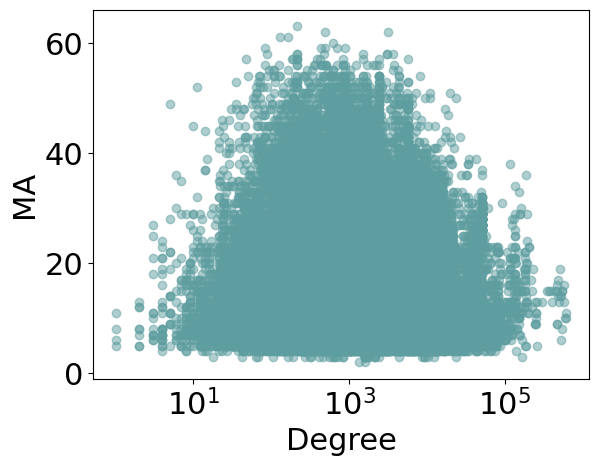

In [47]:
#Visual representation of 0 correlation (lol)
plt.Figure(figsize=(10,10))
plt.scatter(MA_df_filtered["degree"], MA_df_filtered["MA_assemblyGo"], color="cadetblue", alpha=0.5)


plt.xscale("log")

plt.xlabel("Degree")
plt.ylabel("MA")

## Fragment analysis

Do the number / diversity of fragments within the assembly code increase as time goes on? Could this explain MA increase?

In [9]:
### TESTING - need to see if two igraph graphs (C-C=C and C=C-C) are isomorphic

g1 = ig.Graph(3)
g2 = ig.Graph(3)

In [10]:
g1.add_edges([(0,1), (1, 2)])
g2.add_edges([(0,1), (1, 2)])

print(g1)
print("------")
print(g2)

IGRAPH U--- 3 2 --
+ edges:
0--1 1--2
------
IGRAPH U--- 3 2 --
+ edges:
0--1 1--2


In [11]:
#Add edge & vertex colors
g1.vs["color"] = ["C", "C", "C"]
g1.es["color"] = ["single", "double"]

g2.vs["color"] = ["C", "C", "C"]
g2.es["color"] = ["double", "single"]

In [21]:
#Check regular isomorphic (should be true)
print("G1 - iso - G2:", g1.isomorphic(g2))

#Check including colors (should also be true)
print("G1 - iso with colors - G2:", g1.isomorphic_vf2(g2, color1=[4, 4, 4], color2=[4, 4, 4], edge_color1=[-1, -2], edge_color2=[-2, -1]))


G1 - iso - G2: True
G1 - iso with colors - G2: True


In [25]:
from random import randint

In [29]:
#Speed test
graphs = [g1] * 1000000

iso = []
for g in tqdm(graphs):
    iso.append(g.isomorphic_vf2(g2, color1=[randint(0,10), 4, 4], color2=[4, 4, 4], edge_color1=[randint(0,10), -2], edge_color2=[-2, -1]))

100%|██████████| 1000000/1000000 [00:04<00:00, 241006.41it/s]


In [28]:
print(iso[0:100])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
